In [1]:
import sys
sys.path.append('..')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sfp_nsdsyn import *
import warnings
import itertools

import matplotlib as mpl

warnings.filterwarnings("ignore", category=RuntimeWarning)
pd.options.mode.chained_assignment = None
%load_ext autoreload
%autoreload 2

In [19]:
output_dir='/Volumes/server/Projects/sfp_nsd/derivatives'
results_dir = os.path.join(output_dir, 'sfp_model', 'results_2D')
fig_dir = os.path.join(output_dir, 'figures', 'sfp_model', 'results_2D')
lr = 0.0005
max_epoch = 30000
dset='nsdsyn'
roi_list = ['V1','V2','V3']
vsc='pRFsize'
nsd_subj_list = [utils.sub_number_to_string(sn, 'nsdsyn') for sn in np.arange(1,9)]
broderick_sn_list = [1, 6, 7, 45, 46, 62, 64, 81, 95, 114, 115, 121]
broderick_subj_list = [utils.sub_number_to_string(i, 'broderick') for i in broderick_sn_list]
ARGS_2D = ['sub','lr','eph','roi']

# NSD 
## model

In [52]:
pt_file_list = []
dset = 'nsdsyn'
for subj, roi in itertools.product(nsd_subj_list, roi_list[:1]):
    file_name = os.path.join(results_dir, dset, f'model-params_lr-{lr}_eph-{max_epoch}_sub-{subj}_roi-{roi}_vs-{vsc}.pt')
    pt_file_list.append(file_name)
nsd_params = model.load_all_models(pt_file_list, *ARGS_2D)

precision_s =  pd.read_csv(os.path.join(output_dir, 'dataframes', dset, 'precision', f'precision-s_dset-{dset}_vs-pRFsize.csv'))
real_df = pd.merge(nsd_params, precision_s[['sub','vroinames','precision']], on=['sub','vroinames'])
real_df['bootstrap'] = 'real'

## Load in bootstraps

In [45]:
pt_file_list = []
dset = 'nsdsyn'
n_bootstrap = 100
for subj, roi in itertools.product(nsd_subj_list, roi_list[:1]):
    for i in range(n_bootstrap):
        file_name = os.path.join(results_dir, dset, 'bootstraps', f'bootstrap-{i}_model-params_lr-{lr}_eph-{max_epoch}_sub-{subj}_roi-{roi}_vs-{vsc}.pt')
        pt_file_list.append(file_name)
bootstrap_params = model.load_all_models(pt_file_list, *ARGS_2D+['bootstrap'])

## organize dataframes

In [53]:
param_cols = ['sigma', 'slope', 'intercept', 'p_1', 'p_2', 'p_3', 'p_4', 'A_1', 'A_2']

# Melt bootstrap data to long format
boot_melted = bootstrap_params.melt(id_vars=['bootstrap','sub'], value_vars=param_cols,
                        var_name='parameter', value_name='value')

# Melt real data
real_melted = real_df.melt(id_vars=['sub','bootstrap'], value_vars=param_cols, var_name='parameter', value_name='value')


## Sanity check: bootstrap histogram

In [28]:
sns.set_style('ticks')
sns.set_context('notebook')

for roi in roi_list[:1]:
    for subj in nsd_subj_list:

        v1_df = nsd_df.query('sub == @subj & vroinames == @roi')
        v1_bootstrap_df = bootstrap_params.query('sub == @subj & vroinames == @roi')

        # v1_df = v1_df.copy()
        # v1_df['bootstrap'] = 999 
        # sample_df = pd.concat((v1_df, v1_bootstrap_df), axis=0)

        # Melt bootstrap data to long format
        boot_melted = v1_bootstrap_df.melt(id_vars=['bootstrap'], value_vars=param_cols,
                                var_name='parameter', value_name='value')
        # Melt real data
        real_melted = v1_df[param_cols].melt(value_vars=param_cols, var_name='parameter', value_name='value')
        
        # plot
        g = sns.FacetGrid(data=boot_melted, height=4, aspect=1.5,
                    col='parameter', col_wrap=3, sharey=False, sharex=False)
        g.map(sns.histplot, 'value', color='gray', stat='probability', bins=20)
        for ax, param in zip(g.axes.flat, param_cols):
            real_val = real_melted.query('parameter == @param')['value'].values
            if len(real_val) > 0:
                ax.axvline(real_val[0], color='red', linestyle='--', label='Real\nvalue')
                ax.set_title(f'{param}')
            g.axes[0].legend()

        g.fig.suptitle(f'{subj}', fontsize=12, fontweight='bold')
        fig_path = os.path.join(fig_dir, 'bootstraps', f'bootstrap_param_hist_{subj}_V1.png')
        plt.tight_layout()
        utils.save_fig(fig_path)
        plt.close(g.fig)
    

In [47]:
# Compute 16th and 84th percentiles for each group
ci_df = boot_melted.groupby(['sub', 'parameter'])['value'].quantile([0.16, 0.84]).unstack(level=-1).reset_index()
ci_df = ci_df.rename(columns={0.16: 'ci_low_16', 0.84: 'ci_high_84'})


In [57]:
plot_df =pd.merge(real_melted, ci_df, on=['sub', 'parameter'])

# Compute error bar length
plot_df['yerr_lower'] = plot_df['value'] - plot_df['ci_low_16']
plot_df['yerr_upper'] = plot_df['ci_high_84'] - plot_df['value']
#yerr = np.vstack([plot_df['yerr_lower'], plot_df['yerr_upper']])
plot_df

,sub,bootstrap,parameter,value,ci_low_16,ci_high_84,yerr_lower,yerr_upper
0,subj01,real,sigma,2.543468,2.395660,2.669181,0.147809,0.125713
1,subj02,real,sigma,1.939601,1.904160,2.094369,0.035441,0.154768
2,subj03,real,sigma,2.354656,2.130229,2.458407,0.224427,0.103752
3,subj04,real,sigma,1.942886,1.858707,2.003816,0.084179,0.060931
4,subj05,real,sigma,2.365275,2.172823,2.394941,0.192452,0.029666
...,...,...,...,...,...,...,...,...
67,subj04,real,A_2,-0.017066,-0.035295,-0.014718,0.018229,0.002348
68,subj05,real,A_2,-0.002528,-0.021880,-0.008748,0.019353,-0.006221
69,subj06,real,A_2,-0.026395,-0.041544,-0.025422,0.015149,0.000973
70,subj07,real,A_2,0.011840,-0.015151,-0.003643,0.026991,-0.015483


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


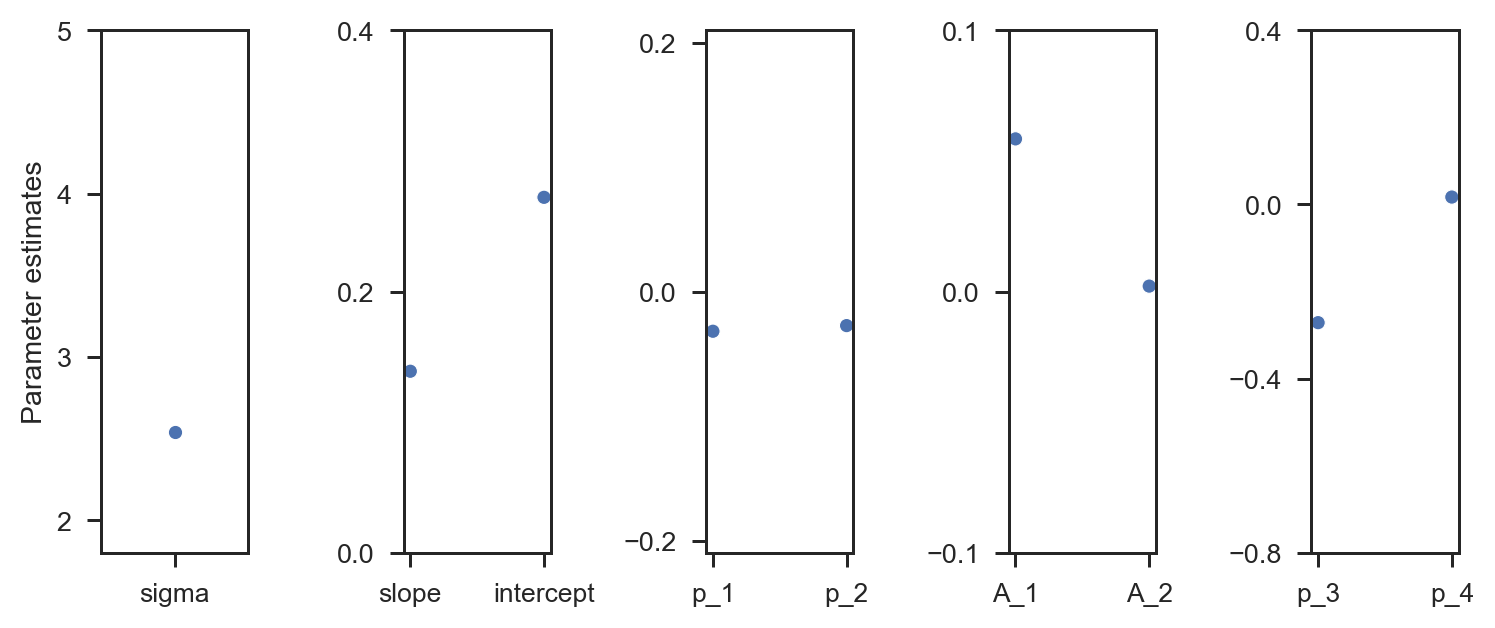

In [ ]:
import matplotlib as mpl
sns.set_context('notebook')
sns.set_style('ticks')
rc = {
        'axes.titlesize': 11,
        'axes.titlepad': 20,
        'axes.labelsize': 9.5,
        'ytick.labelsize': 9,
        'legend.title_fontsize': 9.5,
    'legend.fontsize': 9.5,
        }
sns.set_theme("paper", style='ticks', rc=rc)

# Plot parameters in each ax. For each subject, plot real data as a dot and CI
fig, axes = plt.subplots(figsize=(7, 3), nrows=1, ncols=len(params_list), sharex=False, dpi=72*3)
colors = sns.color_palette('tab10', len(nsd_subj_list))

for i,ax in enumerate(axes.flatten()):
    param = params_list[i]
    row = plot_df.query('parameter in @param')
    sns.scatterplot(data=row, x='parameter', y='value', hue='sub', ax=ax)
    ax.set_ylim(ylim_list[i])
    ax.set_yticks(yticks_list[i])
    ax.set_ylabel('')
    ax.set_xlabel('')
axes[0].set_ylabel('Parameter estimates')
axes[-1].legend(bbox_to_anchor=(1.05, 1), loc='best', frameon=False)
plt.tight_layout()


In [105]:
plot_df =pd.merge(real_melted, ci_df, on=['sub', 'parameter'])

# Compute error bar length
plot_df['yerr_lower'] = plot_df['value'] - plot_df['ci_low_16']
plot_df['yerr_upper'] = plot_df['ci_high_84'] - plot_df['value']
tmp = plot_df.query('sub == "subj01"')

In [ ]:
tmp.query('sub == "subj01"')

,sub,bootstrap,parameter,value,ci_low_16,ci_high_84,yerr_lower,yerr_upper
0,subj01,real,sigma,2.543468,2.395660,2.669181,0.147809,0.125713
8,subj01,real,slope,0.139035,0.134277,0.159637,0.004759,0.020602
16,subj01,real,intercept,0.272089,0.203805,0.293229,0.068284,0.021140
24,subj01,real,p_1,-0.031878,-0.096300,-0.040667,0.064423,-0.008789
32,subj01,real,p_2,-0.027353,-0.018318,0.009947,-0.009035,0.037300
40,subj01,real,p_3,-0.271373,-0.345328,-0.118854,0.073955,0.152518
48,subj01,real,p_4,0.016860,-0.045172,0.071790,0.062032,0.054930
56,subj01,real,A_1,0.058395,0.069839,0.084005,-0.011444,0.025611
64,subj01,real,A_2,0.002084,-0.017637,-0.009191,0.019721,-0.011275


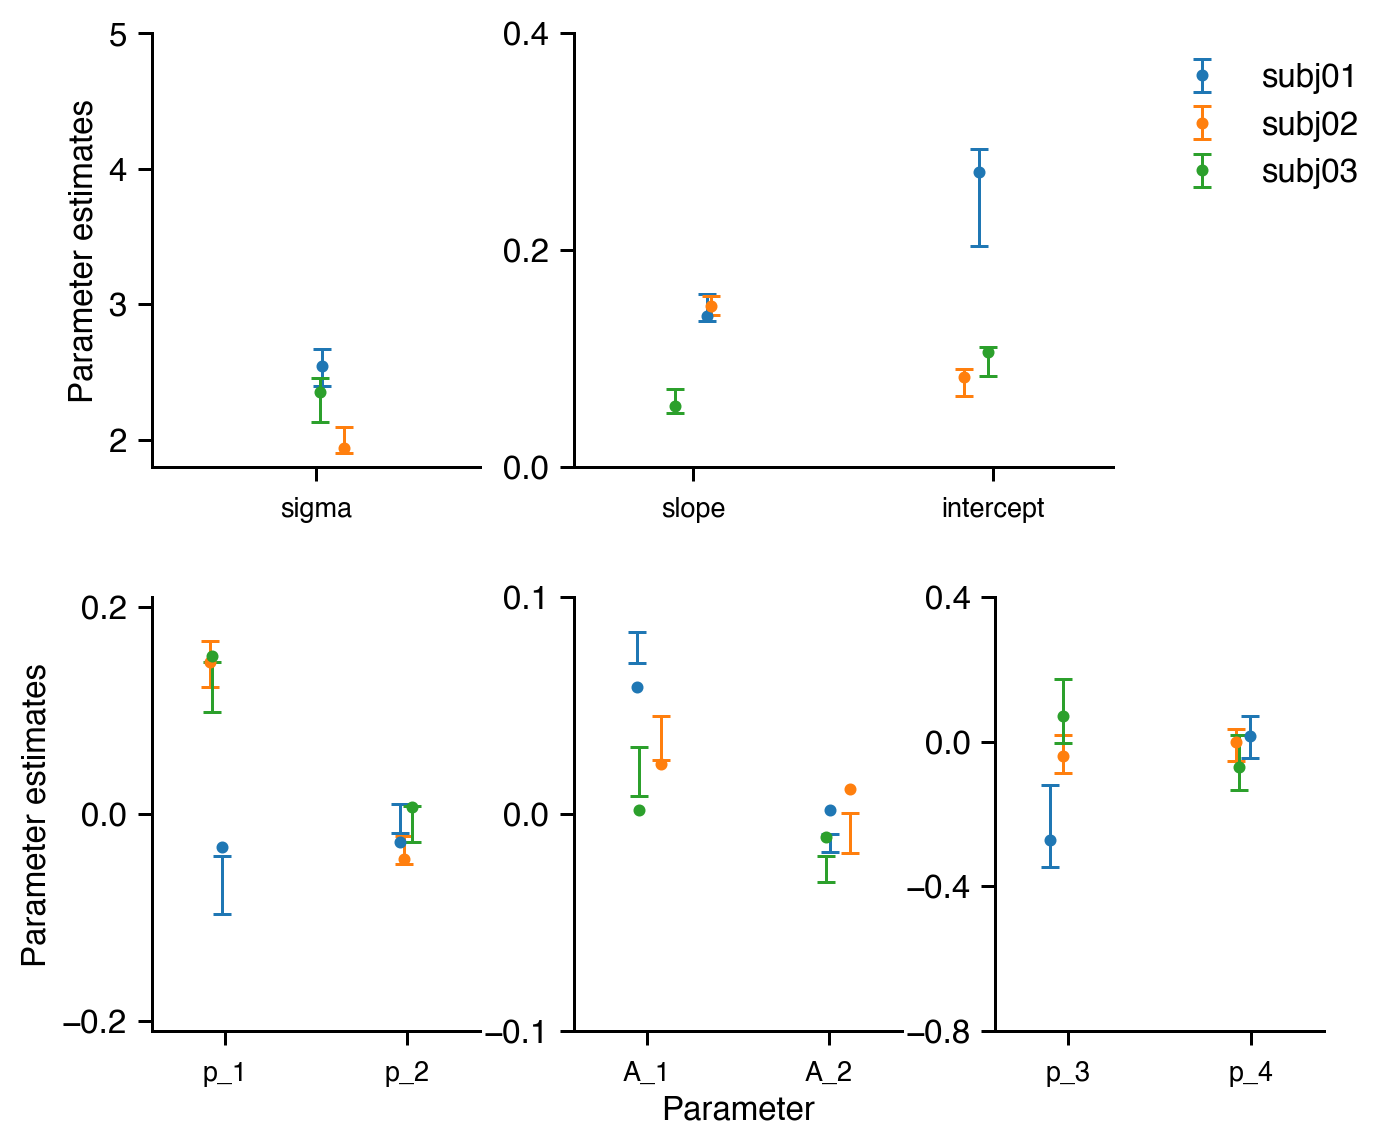

In [196]:

ylim_list = [(1.8, 5), (0, 0.4), (-0.21, 0.21),  (-0.1,0.1), (-0.8, 0.4)]
yticks_list=  [[2,3,4,5], [0, 0.2, 0.4], [-0.2,0,0.2], [-0.1,0,0.1],[-0.8,-0.4,0,0.4]]
params_list = [['sigma'], ['slope', 'intercept'], ['p_1', 'p_2'], ['A_1','A_2'], ['p_3','p_4']]

vis2D.plot_individual_parameters(plot_df,
                                 x='parameter',
                                 y='value', 
                                 hue='sub', 
                                 hue_order=nsd_subj_list[:3], 
                                 params_list=params_list, 
                                 ylim_list=ylim_list, 
                                 yticks_list=yticks_list)

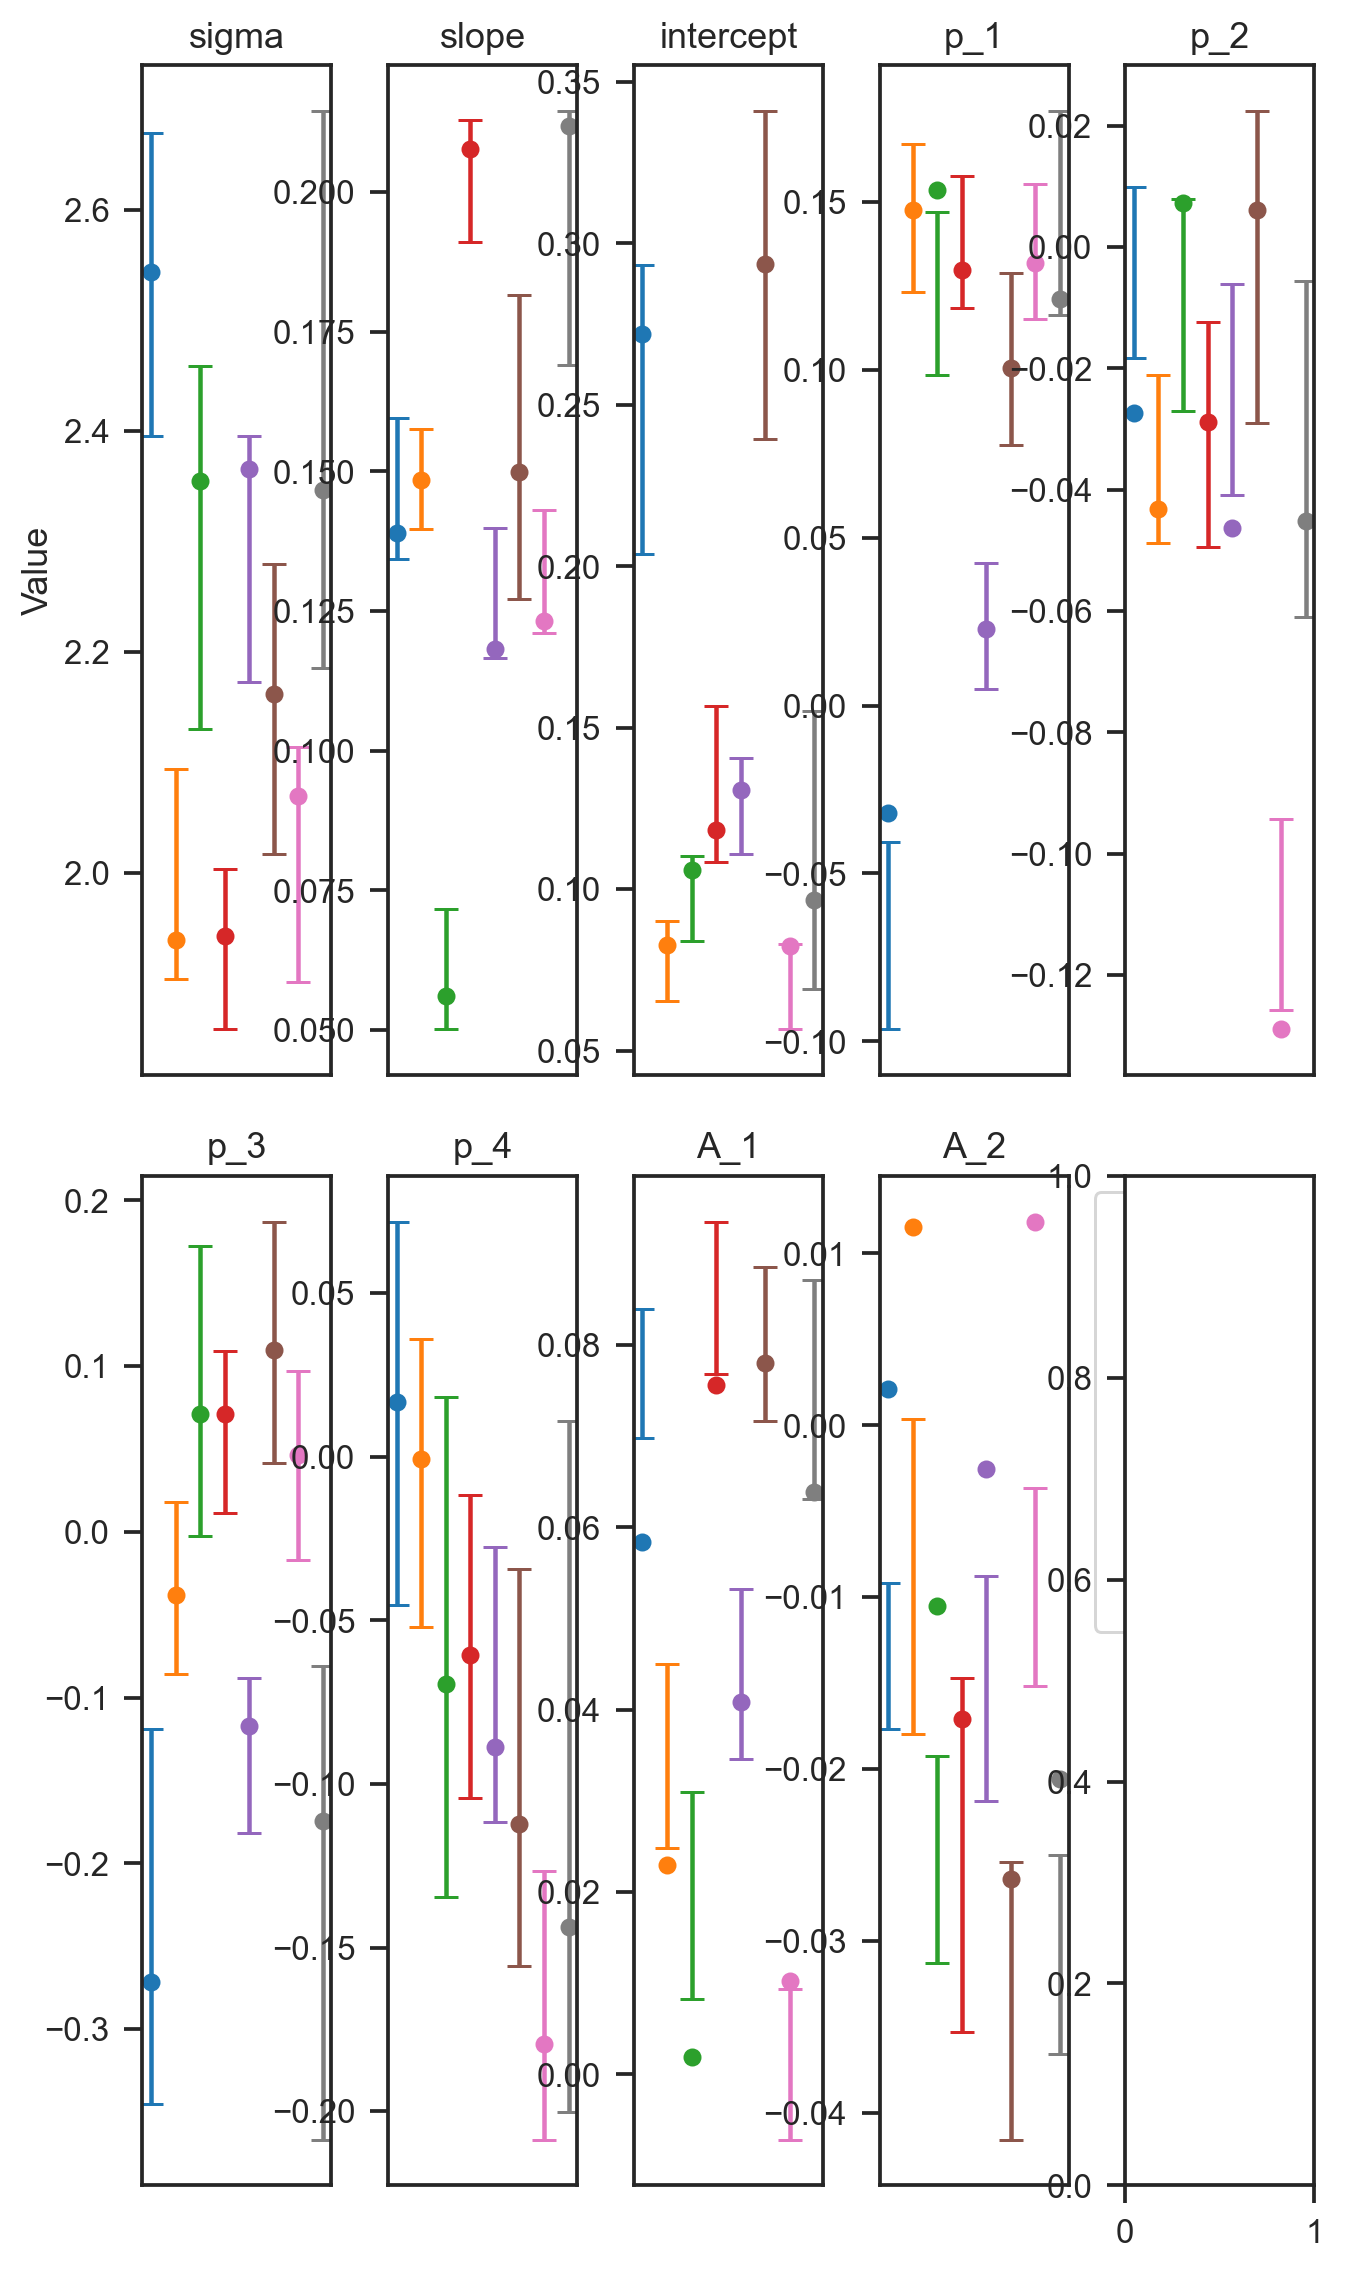

In [86]:

# X locations and labels
x = np.arange(len(plot_df))
labels = plot_df['parameter']

# Plot parameters in each ax. For each subject, plot real data as a dot and CI
fig, axes = plt.subplots(figsize=(7, 13), nrows=2, ncols=5, sharex=False, dpi=72*3)
if len(param_cols) == 1:
    axes = [axes]  # Ensure axes is always iterable

colors = sns.color_palette('tab10', len(nsd_subj_list))

for ax, param in zip(axes.flatten(), param_cols):
    # Select all rows for this parameter
    param_rows = plot_df[plot_df['parameter'] == param]
    if not param_rows.empty:
        y = param_rows['value'].values
        yerr_lower = param_rows['yerr_lower'].values
        yerr_upper = param_rows['yerr_upper'].values
        x = np.arange(len(param_rows))
        subs = param_rows['sub'].values

        # Plot each subject's real value as a dot with CI, using a different color for each subject
        for i, (xi, yi, yl, yu, sub) in enumerate(zip(x, y, yerr_lower, yerr_upper, subs)):
            color = colors[i % len(colors)]
            ax.errorbar(
                xi, yi,
                yerr=[[yl], [yu]],
                fmt='o',
                capsize=4,
                markersize=5,
                color=color,
                label=sub if param == param_cols[-1] else None
            )

    ax.set_xticks(range(len(param_rows)))
    ax.set_xticklabels(param_rows['sub'].values, rotation=45)
    ax.set_xticks([])
    ax.set_xlabel('')
    plt.subplots_adjust(wspace=0.3, hspace=0.1)
    if param == param_cols[0]:
        ax.set_ylabel('Value')
    else:
        ax.set_ylabel('')
    ax.set_title(f'{param}')
    if param == param_cols[-1]:
        # Only show one legend entry per subject
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), title='Subject', bbox_to_anchor=(1.05, 1), loc='upper left')


In [81]:
param_rows

,sub,bootstrap,parameter,value,ci_low_16,ci_high_84,yerr_lower,yerr_upper
0,subj01,real,sigma,2.543468,2.395660,2.669181,0.147809,0.125713
1,subj02,real,sigma,1.939601,1.904160,2.094369,0.035441,0.154768
2,subj03,real,sigma,2.354656,2.130229,2.458407,0.224427,0.103752
3,subj04,real,sigma,1.942886,1.858707,2.003816,0.084179,0.060931
4,subj05,real,sigma,2.365275,2.172823,2.394941,0.192452,0.029666
5,subj06,real,sigma,2.161492,2.016833,2.279199,0.144659,0.117707
6,subj07,real,sigma,2.069652,1.901536,2.113847,0.168116,0.044195
7,subj08,real,sigma,2.345951,2.185500,2.689057,0.160451,0.343106


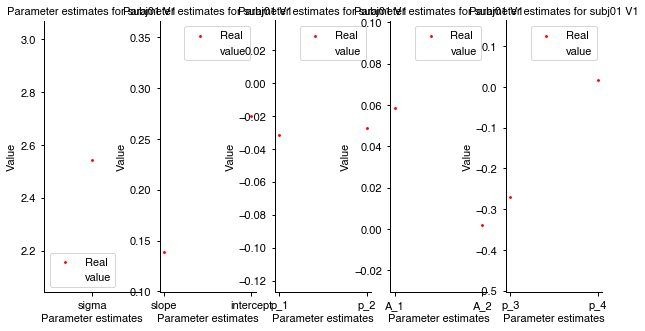

In [7]:
params_list = [['sigma'], ['slope', 'intercept'], ['p_1', 'p_2'], ['A_1', 'A_2'], ['p_3', 'p_4']]
fig, axes = plt.subplots(figsize=(10, 5), nrows=1, ncols=len(params_list))

for i, param in enumerate(params_list):
    ax = axes[i]
    ax = sns.scatterplot(ax=ax, data=real_melted.query('parameter in @param'), 
                         x='parameter', y='value', color='red', s=10, zorder=10, label='Real')
    ax.errorbar(data=boot_melted.query('parameter in @param'),
                 x='parameter', y='value', linestyle='', color='red')
    ax.set_xlabel('Parameter estimates')
    ax.set_ylabel('Value')
    ax.set_title('Parameter estimates for subj01 V1')
    ax.legend()

ax.set_xlabel('Parameter estimates')
ax.set_ylabel('Value')
ax.set_title('Parameter estimates for subj01 V1')
ax.legend()
plt.show()


In [ ]:
params_list = [['sigma'], ['slope', 'intercept'], ['p_1', 'p_2'], ['A_1', 'A_2'], ['p_3', 'p_4']]
ylim_list = [(1, 3), (0, 0.42), (-0.2, 0.2),(-0.1, 0.1), (-0.2, 0.2)]
yticks_list=  [[1,2,3], [0, 0.2, 0.4], [-0.2,0,0.2], [-0.1,0,0.1], [-0.2,0,0.2]]
vis2D.make_param_summary_fig(tmp, hue='sub', hue_order=nsd_subj_list, 
                             pal=sns.color_palette('tab10'), scale=0.8, 
                             width_ratios=(0.8,2,1.5,1.5,1.5), fig_size=(8.6, 1.5),
                             params_list=params_list)

# Weighted-mean for each parameter

In [8]:
PARAMS_2D = ['sigma', 'slope', 'intercept', 'p_1', 'p_2', 'p_3', 'p_4', 'A_1', 'A_2']
utils.calculate_weighted_mean(final_df, PARAMS_2D, 'precision', groupby=['dset_type','goal'])

,dset_type,goal,sigma,slope,intercept,p_1,p_2,p_3,p_4,A_1,A_2
0,Broderick et al. V1,Replication,2.274352,0.115475,0.371032,0.070086,-0.027745,0.058010,-0.004963,0.045074,-0.004617
1,NSD V1,Extension,2.199299,0.150471,0.171367,0.080991,-0.021897,-0.036557,-0.065930,0.057589,-0.019375
2,NSD V1,Replication,2.199299,0.150471,0.171367,0.080991,-0.021897,-0.036557,-0.065930,0.057589,-0.019375
3,NSD V2,Extension,3.797996,0.171325,0.253642,0.161812,-0.102574,-0.342089,0.039329,0.046426,-0.024967
4,NSD V3,Extension,4.461167,0.167584,0.202358,0.051839,-0.046833,-0.463685,0.042397,0.043957,-0.012346


# Plot parameter estimates

(<Figure size 1857.6x324 with 5 Axes>,
 array([<AxesSubplot:ylabel='Parameter estimates'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

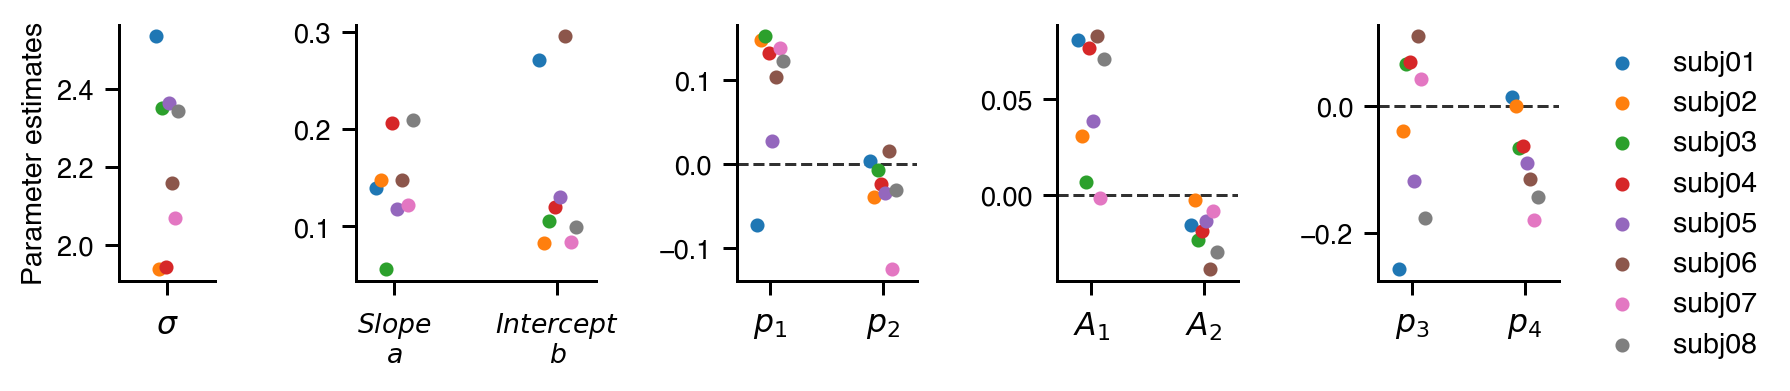

In [ ]:
tmp = final_df.query('dset_type == "NSD V1"')
params_list = [['sigma'], ['slope', 'intercept'], ['p_1', 'p_2'], ['A_1', 'A_2'], ['p_3', 'p_4']]
ylim_list = [(1, 3), (0, 0.42), (-0.2, 0.2),(-0.1, 0.1), (-0.2, 0.2)]
yticks_list=  [[1,2,3], [0, 0.2, 0.4], [-0.2,0,0.2], [-0.1,0,0.1], [-0.2,0,0.2]]
vis2D.make_param_summary_fig(tmp, hue='sub', hue_order=nsd_subj_list, 
                             pal=sns.color_palette('tab10'), scale=0.8, 
                             width_ratios=(0.8,2,1.5,1.5,1.5), fig_size=(8.6, 1.5),
                             params_list=params_list)

(<Figure size 1857.6x324 with 5 Axes>,
 array([<AxesSubplot:ylabel='Parameter estimates'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

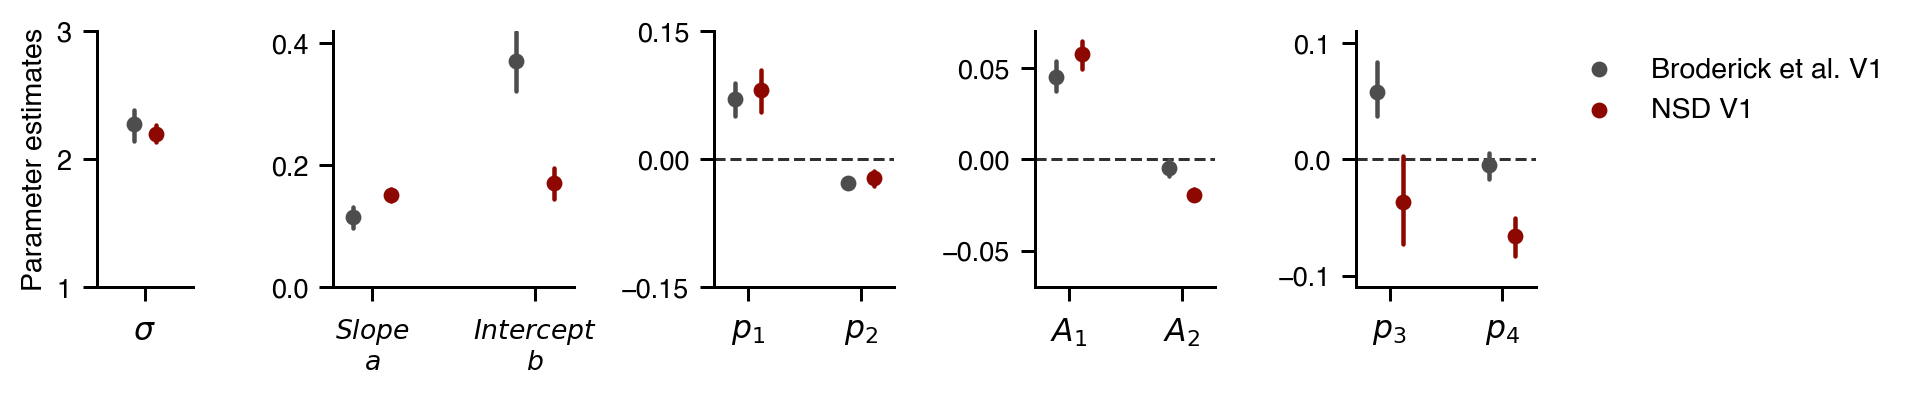

In [20]:
tmp, hue_order, pal = vis2D.filter_for_goal(final_df, 'Replication')
ylim_list = [(1, 3), (0, 0.42), (-0.2, 0.2),(-0.1, 0.1), (-0.2, 0.2)]
yticks_list=  [[1,2,3], [0, 0.2, 0.4], [-0.2,0,0.2], [-0.1,0,0.1], [-0.2,0,0.2]]
params_list = [['sigma'], ['slope', 'intercept'], ['p_1', 'p_2'], ['A_1', 'A_2'], ['p_3', 'p_4']]
title_list = ['Bandwidth', 'Eccentricity effect', 'Absolute orientation effect\non preferred period', 'Amplitude', 'Relative orientation effect\non preferred period']
vis2D.make_param_summary_fig(tmp, 'dset_type', ['Broderick et al. V1', 'NSD V1'], pal, 
                           params_list, ylim_list, yticks_list, title_list=None,
                           width_ratios=(0.8,2,1.5,1.5,1.5), fig_size=(8.6, 1.5),
                           scale=0.9, errwidth=1.5,
                           save_path=os.path.join(fig_dir, 'sfp_model', 'results_2D', 'replication','goal-replication_lr-0.0005_eph-30000_vs-pRFsize.svg'))
#g.margins(x=0.1)

(<Figure size 1857.6x324 with 5 Axes>,
 array([<AxesSubplot:ylabel='Parameter estimates'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

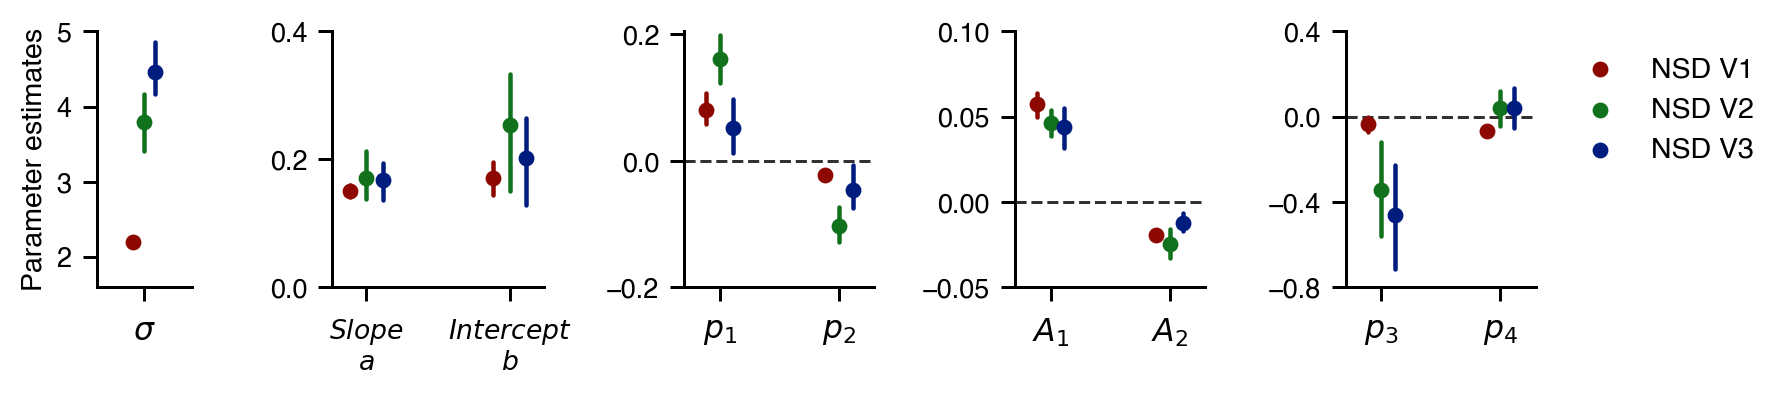

In [21]:
tmp, hue_order, pal = vis2D.filter_for_goal(final_df, 'extension')
ylim_list = [(1.6, 5), (0, 0.4), (-0.2, 0.205),(-0.05, 0.1), (-0.8, 0.4)]
yticks_list=  [[2, 3, 4, 5], [0, 0.2, 0.4], [-0.2,0,0.2], [-0.05,0,0.05,0.1], [-0.8,-0.4,0,0.4]]
params_list = [['sigma'], ['slope', 'intercept'], ['p_1', 'p_2'], ['A_1', 'A_2'], ['p_3', 'p_4']]
title_list = ['Bandwidth', 'Eccentricity effect', 'Absolute orientation effect\non preferred period', 'Amplitude', 'Relative orientation effect\non preferred period']
vis2D.make_param_summary_fig(tmp, 'dset_type', hue_order, pal, 
                           params_list, ylim_list, yticks_list, title_list=None,
                           width_ratios=(0.9,2,1.8,1.8,1.8), fig_size=(8.6, 1.5),
                           scale=0.9, errwidth=1.5,
                           save_path=os.path.join(fig_dir, 'sfp_model', 'results_2D', 'extension','goal-extension_lr-0.0005_eph-30000_vs-pRFsize.svg'))